In [2]:
import numpy as np
from numpy import linalg as LA
import pandas as pd

import json
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, RocCurveDisplay, auc
from tqdm import tqdm

In [3]:
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
embeddings_path = "./embeddings/"
model_save_path = "ovr-norm"
test_size = 0.2
val_size = 0.2
batch_size = 32
num_classes = 5

In [4]:
class EmbeddingsLoader(tf.keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size, emb_dir):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.emb_dir = emb_dir

  def __len__(self):
    return int(np.ceil(len(self.x) / self.batch_size))

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) *
    self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

    batchEmbs = []
    for fileName in batch_x:
        emb = np.load(self.emb_dir + fileName + ".npy")[0]
        batchEmbs.append(emb)
    batchEmbs = np.array(batchEmbs)
    return batchEmbs/255, np.array(batch_y)

In [5]:
data_df = pd.read_csv(csv_path)
data_df_known = data_df.loc[data_df["classID"] < num_classes]
data_df_unknown = data_df.loc[data_df["classID"] >= num_classes]

X_trainval, X_test, y_trainval, y_test = train_test_split(data_df_known['slice_file_name'].tolist(), data_df_known['classID'].tolist(), test_size=test_size, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_size, random_state = 42)
X_trash, X_unknown, y_trash, y_unknown = train_test_split(data_df_unknown['slice_file_name'].tolist(), data_df_unknown['classID'].tolist(), test_size=test_size, random_state = 42)
y_unknown = [num_classes] * len(y_unknown)

X_test = X_test + X_unknown
y_test = y_test + y_unknown
test_loader = EmbeddingsLoader(X_test, y_test, batch_size, embeddings_path)

# 2D array of loaders. Train and val loader for each known class
loaders=[]
for i in range(num_classes):
    loaders.append([])
    ovr_y_train = [1 if j == i else 0 for j in y_train]
    ovr_y_val = [1 if j == i else 0 for j in y_val]
    loaders[i].append(EmbeddingsLoader(X_train, ovr_y_train, batch_size, embeddings_path))
    loaders[i].append(EmbeddingsLoader(X_val, ovr_y_val, batch_size, embeddings_path))

In [6]:
# Array of models. One for each known class
models=[]
for i in range(num_classes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(128,)))
    model.add(tf.keras.layers.Dense(2, activation="softmax"))
    model.summary()
    model.compile(
          optimizer="Adam",
          loss="sparse_categorical_crossentropy",
          metrics=["accuracy"])
    models.append(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 258       
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 258       
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 258       
Total params: 258
Trainable params: 258
Non-trainable params: 0
__________________

In [ ]:
for i in range(num_classes):
    earlystopping = EarlyStopping(
                        patience=5, 
                        restore_best_weights=True)
    checkpoint = ModelCheckpoint(
                        model_save_path+str(i), 
                        monitor="val_accuracy", 
                        save_best_only=True)

    models[i].fit(x=loaders[i][0],
              validation_data=loaders[i][1],
              callbacks=[checkpoint, earlystopping],
              epochs=70,
              verbose=1
             )

In [7]:
def evaluate(predicted, expected):
    acc = np.mean(np.array(predicted) == np.array(expected))
    print("Overall accuracy: {}".format(acc))
    acc_dict = {}
    for i in range(len(expected)):
        expected_class = expected[i]
        if expected_class not in acc_dict:
            acc_dict[expected_class] = [0, 0]
        acc_dict[expected_class][1] += 1
        if expected_class == predicted[i]:
            acc_dict[expected_class][0] += 1
    for k,v in acc_dict.items():
        print("Accuracy for class {}: {}".format(k, v[0]/v[1]))
    for average in ["macro", "weighted", "micro"]:
        f1 = f1_score(expected, predicted, average=average)
        print("{} f1 score: {}".format(average, f1))

In [8]:
for i in range(num_classes):
    models[i].load_weights(model_save_path+str(i))

In [9]:
for i in range(num_classes):
    models[i].save(model_save_path+str(i)+".model")
for i in range(num_classes):
    models[i] = tf.keras.models.load_model(model_save_path+str(i)+".model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ovr-norm0.model/assets
INFO:tensorflow:Assets written to: ovr-norm1.model/assets
INFO:tensorflow:Assets written to: ovr-norm2.model/assets
INFO:tensorflow:Assets written to: ovr-norm3.model/assets
INFO:tensorflow:Assets written to: ovr-norm4.model/assets


In [14]:
y_predicted = []
y_random = []
y_scores = []
for data, labels in tqdm(test_loader):
    for i in range(len(data)):
        probabilities = []
        for j in range(num_classes):
            probabilities.append(models[j].predict(x=np.array([data[i]]))[0][1])
        best_class = np.argmax(probabilities)
        highest_prob = probabilities[best_class]
        if highest_prob < 0.5:
            y_predicted.append(num_classes)
        else:
            y_predicted.append(best_class)
        y_scores.append(highest_prob)
        y_random.append(np.random.randint(num_classes + 1))

100%|██████████| 55/55 [03:04<00:00,  3.36s/it]


Overall accuracy: 0.5540927303949628
Accuracy for class 2: 0.7487684729064039
Accuracy for class 4: 0.7325581395348837
Accuracy for class 0: 0.7416267942583732
Accuracy for class 3: 0.6008771929824561
Accuracy for class 1: 0.7702702702702703
Accuracy for class 5: 0.39605110336817656
macro f1 score: 0.5882510076616984
weighted f1 score: 0.550871415534586
micro f1 score: 0.5540927303949628
Overall accuracy: 0.15741270749856898
Accuracy for class 2: 0.13793103448275862
Accuracy for class 4: 0.19767441860465115
Accuracy for class 0: 0.15311004784688995
Accuracy for class 3: 0.14035087719298245
Accuracy for class 1: 0.22972972972972974
Accuracy for class 5: 0.15331010452961671
macro f1 score: 0.1387939078578404
weighted f1 score: 0.17763869644227584
micro f1 score: 0.15741270749856898


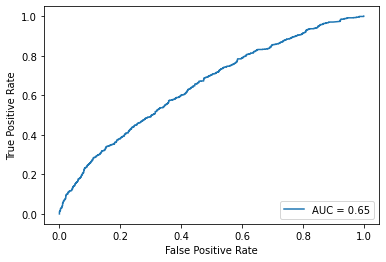

In [15]:
evaluate(y_predicted, y_test)
evaluate(y_random, y_test)
y_posneg = [0 if i == num_classes else 1 for i in y_test]
fpr, tpr, thresholds = roc_curve(y_posneg, y_scores)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = roc_auc)
display.plot()